## Feature Engineering
- 목적
    - 시간 개념이 들어간 추가 Feature 생성
- 배울 내용
    - BigQuery Window(Analytics) Function
    
- 추가할 Feature
    - 1시간 전, 1일(=24시간) 전, 7일(=168시간) 전 해당 zip_code의 수요
    - 여기서 주의할 점
        - 그냥 과거 데이터 기준으로 window 함수 걸고 168시간 전 값을 가져오라고 하면 안됨
        - 혹시나 비어있는 값이 있을수도 있음..!
        - 따라서 비어있지 않은 시간 데이터를 생성한 후, zip_code와 cross join
        - 그 후에 해당 zip_code, datetime별 과거 demand 데이터를 join
- [BigQuery의 모든 것 138쪽](https://www.slideshare.net/zzsza/bigquery-147073606#138)

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import os
from sacred import Experiment
from sacred.observers import FileStorageObserver
from sklearn.ensemble import RandomForestRegressor
import json

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

PROJECT_ID='geultto' # 여기에 여러분들의 프로젝트 ID를 넣어주세요

In [2]:
ex = Experiment('nyc-demand-prediction', interactive=True)

# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

### 전처리

In [3]:
%%time
base_query = """
WITH base_data AS 
(
  SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
  FROM (
    SELECT *
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    WHERE 
        EXTRACT(MONTH from pickup_datetime) = 1
        and pickup_latitude  <= 90 and pickup_latitude >= -90
    ) AS nyc_taxi
  JOIN (
    SELECT zip_code, state_code, state_name, city, county, zip_code_geom
    FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
    WHERE state_code='NY'
    ) AS gis 
  ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
), distinct_datetime AS (
  # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
  SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
  FROM base_data
), distinct_zip_code AS (
  # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
  SELECT distinct zip_code
  FROM base_data
), zip_code_datetime_join AS (
  # zip_code와 datetime을 join
  SELECT
    *,
    EXTRACT(MONTH FROM pickup_hour) AS month,
    EXTRACT(DAY FROM pickup_hour) AS day,
    CAST(format_datetime('%u', pickup_hour) AS INT64) -1 AS weekday,
    EXTRACT(HOUR FROM pickup_hour) AS hour,
    CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
  FROM distinct_zip_code  
  CROSS JOIN distinct_datetime
), agg_data AS (
  # zip_code, datetime별 수요 
  SELECT 
      zip_code,
      DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
      COUNT(*) AS cnt
  FROM base_data 
  GROUP BY zip_code, pickup_hour
), join_output AS (
  # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
  select 
    zip_code_datetime.*, 
    IFNULL(agg_data.cnt, 0) AS cnt
  from zip_code_datetime_join as zip_code_datetime
  LEFT JOIN agg_data
  ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)
SELECT
  *,
  LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
  LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
  LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
  LAG(cnt, 336) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_14d_cnt,
  ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING), 2) AS avg_21d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_14d_cnt,
  CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 336 PRECEDING AND 1 PRECEDING) AS INT64) AS std_21d_cnt
FROM join_output
order by zip_code, pickup_hour
"""

base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=PROJECT_ID)

CPU times: user 17.8 s, sys: 952 ms, total: 18.8 s
Wall time: 1min


In [4]:
base_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt
278251,14801,2015-01-31 19:00:00,1,31,5,19,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278252,14801,2015-01-31 20:00:00,1,31,5,20,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278253,14801,2015-01-31 21:00:00,1,31,5,21,1,0,0.0,1.0,0.0,0.0,0.01,0.0,0.0,0.0
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0


In [5]:
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

In [6]:
def split_train_and_test(df, date):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

### Train / Test 나누기

In [7]:
train_df, test_df = split_train_and_test(base_df, '2015-01-24')

In [8]:
train_df.tail()

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
278059,14801,2015-01-23 19:00:00,1,23,4,19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278060,14801,2015-01-23 20:00:00,1,23,4,20,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278061,14801,2015-01-23 21:00:00,1,23,4,21,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278062,14801,2015-01-23 22:00:00,1,23,4,22,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373
278063,14801,2015-01-23 23:00:00,1,23,4,23,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,373


- 사용하지 않을 컬럼 삭제

In [9]:
del train_df['zip_code']
del train_df['pickup_hour']
del test_df['zip_code']
del test_df['pickup_hour']

In [10]:
train_df.head(2)

,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,lag_14d_cnt,avg_14d_cnt,avg_21d_cnt,std_14d_cnt,std_21d_cnt,zip_code_le
0,1,1,3,0,0,1221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,1,3,1,0,1151,1221.0,NaN,NaN,NaN,1221.0,1221.0,NaN,NaN,0


In [11]:
y_train_raw = train_df.pop('cnt')
y_test_raw = test_df.pop('cnt')

In [12]:
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

In [13]:
x_train = train_df.copy()
x_test = test_df.copy()

In [14]:
len(x_train)

206448

In [15]:
len(x_test)

71808

- 데이터가 많아진 이유
    - zip_code, datetime별로 빈 값이 많이 생김

### 모델링

In [16]:
def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [17]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [18]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [19]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [20]:
%%time
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "6"
INFO - nyc-demand-prediction - Result: {'mape': {'score': nan}, 'mae': {'score': 7.146781695632797}, 'mse': {'score': 1096.2502307542331}}
INFO - nyc-demand-prediction - Completed after 0:00:03


CPU times: user 12.9 s, sys: 296 ms, total: 13.2 s
Wall time: 3.44 s


In [21]:
experiment_result.config

{'n_estimators': 10, 'n_jobs': -1, 'seed': 92017923}

In [22]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
    output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [23]:
parsing_output(6)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,6,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 920...",7.146782,None,1096.250231


In [24]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 635...",35.292444,182.606663,12276.947911


In [25]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.901979,412.772891,13734.183106


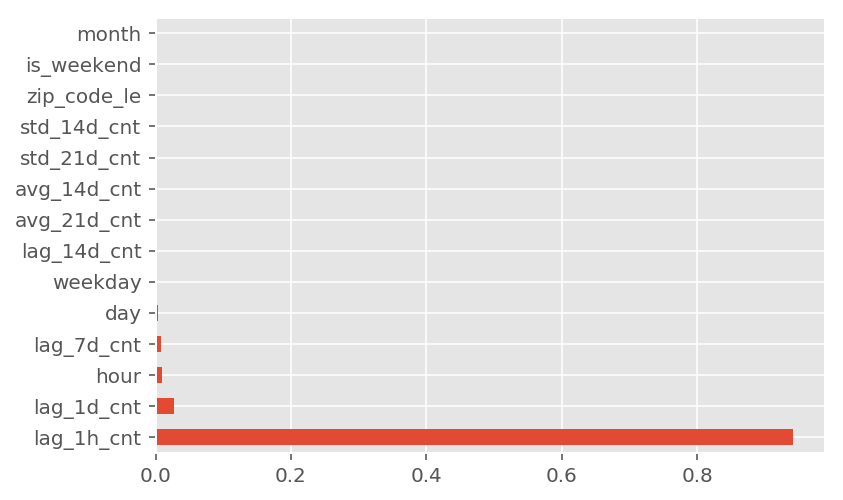

In [26]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh');

### 결과 분석
- 어떤 알고리즘이 제일 성능이 좋았는지?

In [27]:
parsing_output(3)

,model_name,experiment_num,config,mae,mape,mse
score,XGBRegressor,3,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",57.678736,538.520173,16512.330211


In [28]:
parsing_output(4)

,model_name,experiment_num,config,mae,mape,mse
score,LGBMRegressor,4,"{'learning_rate': 0.1, 'max_depth': -1, 'n_est...",47.901979,412.772891,13734.183106


In [29]:
parsing_output(5)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,5,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 635...",35.292444,182.606663,12276.947911


In [30]:
parsing_output(6)

,model_name,experiment_num,config,mae,mape,mse
score,RandomForestRegressor,6,"{'n_estimators': 10, 'n_jobs': -1, 'seed': 920...",7.146782,None,1096.250231


- MAPE
    - None이 나온 이유 : y_true 값이 0
    - MAPE가 Outlier에 영향을 덜 받고 해석하기 쉬운 장점이 있지만, 실제 값이 0인 경우 0으로 나누게 됨
    - [MAPE 단점에 대해 잘 나온 문서](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape)
    - [MAPE 단점에 대해 잘 나온 문서2](https://stats.stackexchange.com/questions/280464/is-mape-a-good-error-measurement-statistic-and-what-alternatives-are-there)
- 해결 방법
    - 분모에 Epsilon을 추가하는 방법 : [forecasting metrics.py 참고](https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9)
    - Inf / None 같은 invalid를 제외하는 방법
    - 새로운 Metric을 사용하는 방법
        - [SMAPE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error), [MASE](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error)

### Data 복구
- Label Encoding, 삭제한 데이터, Datetime 등 다시 reverse encoding

In [31]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = rf_pred
test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])
test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

In [32]:
test_df = test_df.set_index('datetime')

### Datetime별 차이

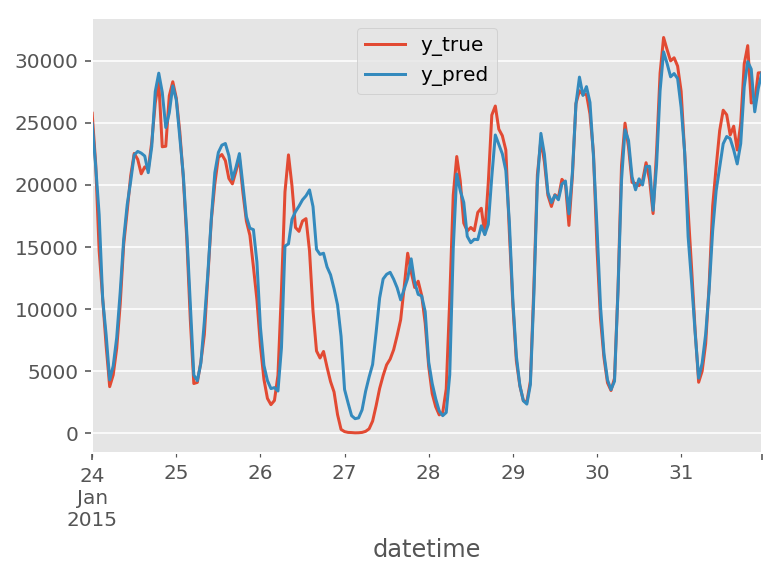

In [33]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

### Zip code별 차이

In [34]:
def visualize_output_by_zipcode(df):
    def view_images(zip_code):
        data = df.loc[df['zip_code'] == str(zip_code)][['y_true', 'y_pred']]
        try:
            ax = data.plot();
            ax.set_title(f'zip_code : {zip_code}')
        except:
            pass
        
    interact(view_images, zip_code=(10001, 10200))

In [35]:
visualize_output_by_zipcode(test_df)

interactive(children=(IntSlider(value=10100, description='zip_code', max=10200, min=10001), Output()), _dom_cl…

### Hour별 차이

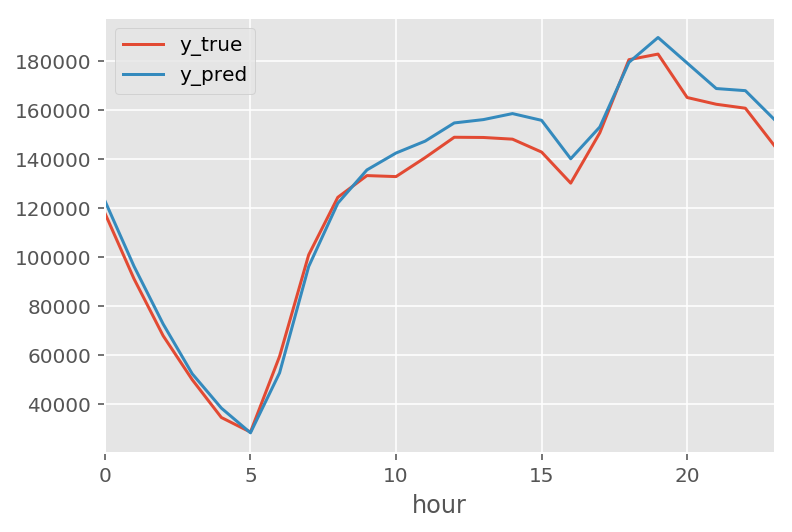

In [36]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

### Weekday별 차이

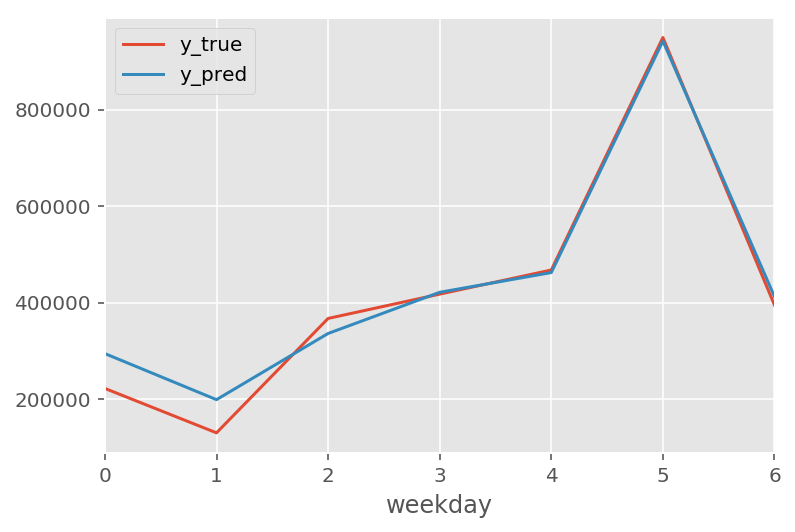

In [37]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

### 평일/주말별 차이

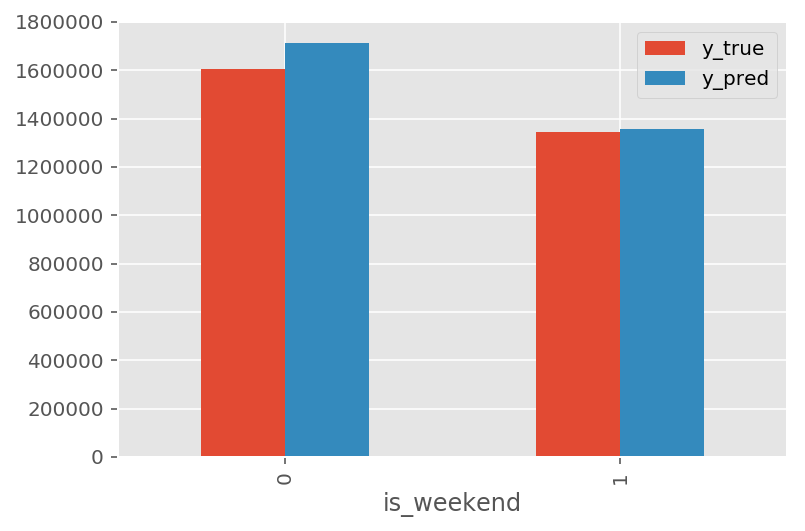

In [38]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');